In [1]:
import cudf
import gc
import lightgbm as lgb
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

****Prepare Dataset****

In [2]:
%%time 
transactions = cudf.read_csv('storage/transactions_train.csv')
articles = cudf.read_csv('storage/articles.csv')
customers = cudf.read_csv('storage/customers.csv')

CPU times: user 1.29 s, sys: 2.36 s, total: 3.65 s
Wall time: 14.7 s


In [3]:
customers['FN'].fillna(0.,inplace=True)
customers['Active'].fillna(0.,inplace=True)
customers['club_member_status'].fillna('None',inplace=True)
customers['age'] = customers['age'] / 10
customers['age'] = customers['age'].astype(int)
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().fillna('none')

In [15]:
customers['customer_group'] = customers['FN'].astype(str)+'_'+customers['Active'].astype(str)+\
                                '_'+customers['club_member_status'].astype(str)+'_'+customers['age'].astype(str)+\
                                '_'+customers['fashion_news_frequency'].astype(str)

In [16]:
transactions['t_dat'] = cudf.to_datetime(transactions['t_dat'])

In [25]:
def past_purchase_feature(df,transactions):
    transactions['count'] = 1
    
    time_elapsed_last_purchase = transactions['t_dat'].max()-transactions[['customer_id','article_id','t_dat']].groupby(['customer_id','article_id'])['t_dat'].max()
    time_elapsed_last_purchase = time_elapsed_last_purchase.dt.days
    df = df.merge(time_elapsed_last_purchase,on=['article_id','customer_id'],how='left')
    df = df.rename(columns={'t_dat':'time_elapsed_last_purchase'})
    df['time_elapsed_last_purchase'].fillna(1e6,inplace=True)
    
    time_elapsed_first_release = transactions[['customer_id','article_id','t_dat']].groupby(['customer_id','article_id'])['t_dat'].min()-cudf.to_datetime('2018-09-01')
    time_elapsed_first_release = time_elapsed_first_release.dt.days
    df = df.merge(time_elapsed_first_release,on=['article_id','customer_id'],how='left')
    df = df.rename(columns={'t_dat':'time_elapsed_first_release'})
    df['time_elapsed_first_release'].fillna(1e6,inplace=True)
    
    past_purchase_prob = transactions[['customer_id','article_id','count']].groupby(['customer_id','article_id'])['count'].count().reset_index()
    norm = transactions[['customer_id','article_id']].groupby('customer_id').count().reset_index().rename(columns={'article_id':'norm'})
    past_purchase_prob = past_purchase_prob.merge(norm,on='customer_id')
    past_purchase_prob['count'] = past_purchase_prob['count'] / past_purchase_prob['norm']
    past_purchase_prob.drop(columns=['norm'],inplace=True)
    df = df.merge(past_purchase_prob,on=['article_id','customer_id'],how='left')
    df = df.rename(columns={'count':'past_purchase_prob'})
    df['past_purchase_prob'].fillna(0.,inplace=True)
    
    total_purchase = transactions[['article_id','count']].groupby('article_id')['count'].count().reset_index().rename(columns={'count':'total_purchase'})
    norm = transactions['count'].sum()
    total_purchase['total_purchase'] = total_purchase['total_purchase'] / norm
    df = df.merge(total_purchase,on='article_id',how='left')
    df['total_purchase'].fillna(0.,inplace=True)
    
    number_of_purchase = transactions[['customer_id','count']].groupby('customer_id')['count'].count().reset_index().rename(columns={'count':'number_of_purchase'})
    df = df.merge(number_of_purchase,on='customer_id',how='left')
    df['number_of_purchase'].fillna(0.,inplace=True)
    
    repeated_purchase = transactions[['customer_id','article_id','count']].groupby(['customer_id','article_id'])['count'].count().reset_index().rename(columns={'count':'repeated_purchase'})
    df = df.merge(repeated_purchase,on=['customer_id','article_id'],how='left')
    
    min_dat_purchase = transactions.groupby(['article_id'])['t_dat'].min()
    max_dat_purchase = transactions.groupby(['article_id'])['t_dat'].max()
    sale_duration = (max_dat_purchase - min_dat_purchase).to_frame().reset_index().rename(columns={'t_dat':'duration'})
    sale_duration['duration'] = sale_duration['duration'].dt.days
    sale_count = transactions.groupby(['article_id'])['t_dat'].count().to_frame().reset_index().rename(columns={'t_dat':'count'})
    sale_rate = sale_duration.merge(sale_count,on='article_id')
    sale_rate = sale_rate.loc[sale_rate['duration']!=0]
    sale_rate['sale_rate'] = sale_rate['count'] / sale_rate['duration']
    df = df.merge(sale_rate[['article_id','sale_rate']],on='article_id',how='left')

    return df
    
def article_feature_prob_vector(df,transactions,articles,article_features,postfix='_prob',customer_group_name='customer_id'):
    transactions['count'] = 1
    if customer_group_name != 'customer_id':
        df = df.merge(customers[['customer_id',customer_group_name]],on='customer_id',how='left')
        transactions = transactions.merge(customers[['customer_id',customer_group_name]],on='customer_id',how='left')
    for article_feature in article_features:
        transactions = transactions.merge(articles[['article_id',article_feature]],on='article_id',how='left')
        norm = transactions.groupby([customer_group_name])['count'].count().reset_index()
        norm.rename(columns={'count':'norm'},inplace=True)
        count = transactions.groupby([customer_group_name,article_feature])['count'].count().reset_index()
        count = count.merge(norm,on=customer_group_name)
        count['count'] = count['count'] / count['norm']
        count = count.rename(columns={'count':article_feature+postfix})
        count = count[[customer_group_name,article_feature,article_feature+postfix]]
        del(norm)
        df = df.merge(articles[['article_id',article_feature]],on='article_id',how='left')
        df = df.merge(count,on=[customer_group_name,article_feature],how='left')
    return df

def customer_feature_prob_vector(df,transactions,customers,customer_features,postfix='_prob'):
    transactions['count'] = 1
    for customer_feature in customer_features:
        transactions = transactions.merge(customers[['customer_id',customer_feature]],on='customer_id',how='left')
        norm = transactions.groupby(['article_id'])['count'].count().reset_index()
        norm.rename(columns={'count':'norm'},inplace=True)
        count = transactions.groupby(['article_id',customer_feature])['count'].count().reset_index()
        count = count.merge(norm,on='article_id')
        count['count'] = count['count'] / count['norm']
        count = count.rename(columns={'count':customer_feature+postfix})
        count = count[['article_id',customer_feature,customer_feature+postfix]]
        del(norm)
        df = df.merge(customers[['customer_id',customer_feature]],on='customer_id',how='left')
        df = df.merge(count,on=['article_id',customer_feature],how='left')
    return df

def construct_feature_df(
        df,transactions,
        article_features,
        articles,
        customer_features,
        customers,
        general_features=['article_id','customer_id'],
    ):
    df = article_feature_prob_vector(df,transactions,articles,article_features,customer_group_name='customer_group')
    df = customer_feature_prob_vector(df,transactions,customers,customer_features)
    df = past_purchase_feature(df,transactions)
    df = df[
            general_features+[f for f in df.columns if '_prob' in f] + 
            ['total_purchase','time_elapsed_last_purchase','past_purchase_prob','number_of_purchase','time_elapsed_first_release','repeated_purchase']
        ]
    return df

def construct_candidate_dict(transactions_3w):
    purchase_dict_3w = {}
    for i,x in enumerate(zip(transactions_3w['customer_id'], transactions_3w['article_id'])):
        cust_id, art_id = x
        if cust_id not in purchase_dict_3w:
            purchase_dict_3w[cust_id] = {}
        if art_id not in purchase_dict_3w[cust_id]:
            purchase_dict_3w[cust_id][art_id] = 0
        purchase_dict_3w[cust_id][art_id] += 1
    dummy_list_3w = list((transactions_3w['article_id'].value_counts()).index)[:12]
    return purchase_dict_3w,dummy_list_3w

def get_week(purchase_dicts,article_id):
    for i,purchase_dict in enumerate(purchase_dicts):
        if article_id in purchase_dict: return i
    return 1e6

def construct_candidate_df(
        test_df,transactions,
        nweek=3,
        add_random_samples=False,n_popular_item=90,
    ):
    
    recent_transactions = {}
    purchase_dict = {}
    for i in range(1,nweek+1):
        recent_transactions[i] = transactions[(transactions.t_dat>transactions.t_dat.max()-i*pd.Timedelta(7,unit='day'))&(transactions.t_dat<=transactions.t_dat.max()-(i-1)*pd.Timedelta(7,unit='day'))].to_pandas()
        purchase_dict[i] = construct_candidate_dict(recent_transactions[i])
    
    most_popular_items_1w_all = list((recent_transactions[1]['article_id'].value_counts()).index)[:12]
    
    pred_df = pd.DataFrame()
    pred_df['customer_id'] = test_df['customer_id'].unique()
    
    prediction_list = []
    
    for i, cust_id in enumerate(pred_df['customer_id']):
        s = []
        total_purchase_dict = {}
        
        for i,purchase_dict_week in purchase_dict.items():
            if cust_id in purchase_dict_week:
                l = sorted((purchase_dict_week[cust_id]).items(), key=lambda x: x[1], reverse=True)
                l = [y[0] for y in l][:12]
                for aid in l:
                    if aid not in total_purchase_dict:
                        total_purchase_dict[aid] = 1
                    else:
                        total_purchase_dict[aid] += 1

        for aid in n_popular_item[:12]:
            if aid not in total_purchase_dict:
                total_purchase_dict[aid] = 1
            else:
                total_purchase_dict[aid] += 1

        total_purchase_dict = {k: v for k, v in sorted(total_purchase_dict.items(), key=lambda item: item[1], reverse=True)}
        s = list(total_purchase_dict.keys())[:12]
        
        prediction_list.append(s)
        
    pred_df['article_id'] = prediction_list
    
    return pred_df
    
def construct_val_df(test_df,transactions,article_features,articles,customer_features,customers,how='outer',add_random_samples=False):
    pos_df = test_df.groupby('customer_id')['article_id'].unique().to_frame().reset_index().explode('article_id')
    pos_df['label'] = 1
    test_df = construct_candidate_df(test_df.to_pandas(),transactions,add_random_samples=add_random_samples).explode('article_id').reset_index(drop=True)
    test_df = test_df.merge(pos_df.to_pandas(),on=['article_id','customer_id'],how=how)
    test_df['label'].fillna(0,inplace=True)
    test_df = cudf.from_pandas(test_df)
    test_df = construct_feature_df(test_df,transactions,article_features,articles,customer_features,customers,general_features=['article_id','customer_id','label'])
    test_df = test_df.fillna(0.)
    test_df['article_id'] = test_df['article_id'].astype(int)
    test_df = test_df.sort_values(['customer_id','article_id']).reset_index(drop=True)
    return test_df

def construct_test_df(test_df,transactions,article_features,articles,customer_features,customers,how='outer',add_random_samples=False,n_popular_item=90):
    test_df = construct_candidate_df(test_df.to_pandas(),transactions,add_random_samples=add_random_samples,n_popular_item=n_popular_item).explode(['article_id']).reset_index(drop=True)
    test_df = cudf.from_pandas(test_df)
    test_df = construct_feature_df(test_df,transactions,article_features,articles,customer_features,customers,general_features=['article_id','customer_id'])
    test_df = test_df.fillna(0.)
    test_df['article_id'] = test_df['article_id'].astype(int)
    test_df = test_df.sort_values(['customer_id','article_id']).reset_index(drop=True)
    return test_df

def construct_gt_df(test_transactions):
    gt_df = test_transactions.to_pandas().groupby('customer_id')['article_id'].agg(lambda x: x.tolist()).reset_index()
    gt_df.columns = ['customer_id','ground_truth']
    return gt_df
    
def construct_dataset(
        transactions,
        articles,customers,
        trn_start_time='2020-08-31',trn_end_time='2020-09-08',
        val_start_time='2020-09-08',val_end_time='2020-09-15',
        test_start_time='2020-09-08',test_end_time='2020-09-15',
        article_features=[
            'product_type_name','product_group_name',
            'graphical_appearance_name','colour_group_name',
            'perceived_colour_value_name','perceived_colour_master_name',
            'department_name', 'index_name',
            'index_group_name','section_name',
            'garment_group_name',
        ],
        customer_features=[
            'FN','Active','club_member_status','age','fashion_news_frequency',
        ],
    ):
    
    trn_start_time = cudf.to_datetime(trn_start_time)
    trn_end_time = cudf.to_datetime(trn_end_time)
    val_start_time = cudf.to_datetime(val_start_time)
    val_end_time = cudf.to_datetime(val_end_time)
    test_start_time = cudf.to_datetime(test_start_time)
    test_end_time = cudf.to_datetime(test_end_time)
    
    trn_transactions = transactions[(transactions.t_dat > trn_start_time) & (transactions.t_dat <= trn_end_time)]
    val_transactions = transactions[(transactions.t_dat > val_start_time) & (transactions.t_dat <= val_end_time)]
    test_transactions = transactions[(transactions.t_dat > test_start_time) & (transactions.t_dat <= test_end_time)]
    gt_df = construct_gt_df(test_transactions)
    
    trn_df = construct_test_df(val_transactions,trn_transactions,article_features,articles,customer_features,customers,how='left',n_popular_item=80)
    pos_label = val_transactions[['article_id','customer_id']].groupby(['article_id','customer_id']).size().to_frame('label')
    pos_label['label'] = pos_label['label'].apply(lambda x: x if x <=20. else 20.)
    trn_df = trn_df.merge(pos_label,on=['article_id','customer_id'],how='left')
    trn_df['label'].fillna(0.,inplace=True)
    
    trn_df = trn_df.merge(trn_df.groupby('customer_id').size().to_frame().rename(columns={0:'group_size'}),on='customer_id')
    test_df = construct_test_df(test_transactions,val_transactions,article_features,articles,customer_features,customers,how='left',n_popular_item=80)
    
    return trn_df.reset_index(drop=True),test_df.reset_index(drop=True),gt_df.reset_index(drop=True)

In [26]:
class LightGBMCollator(object):
    def __init__(self,dfs,features,label,k=12):
        self.dfs = dfs
        self.features = features
        self.label = label
        self.k = k
        
    def x_y_group(self,data,features,target,only_x=False,verbose=False):
        group = data.groupby('customer_id').size().to_frame('size')['size']
        data = data.sort_values('customer_id').reset_index()
        return data[features],data[target],group
        
    def get_train_dataset_by_index(self,index):
        trn_x,trn_y,trn_grp = self.x_y_group(self.dfs[index][0],features,label)
        return trn_x,trn_y,trn_grp
        
    def get_ground_truth_dataset_by_index(self,index):
        return self.dfs[index][-1]
    
    def get_test_dataset_by_index(self,index):
        return self.dfs[index][1]#.to_pandas()
    
    def construct_eval_dataset(self):
        self.gt_df = self.get_ground_truth_dataset_by_index(0)
        self.test_df = self.get_test_dataset_by_index(0)
    
    def evaluate_score(self,pred_df,gt_df,k=12,verbose=True,group_name='customer_id'):
        from metric import mapk
        eval_df = gt_df.merge(pred_df,on=group_name,how='left')
        score = mapk(eval_df['ground_truth'].tolist(),eval_df['prediction'].tolist())
        if verbose: print('map@'+str(k),score)
        return score
    
    def feval(self,preds,eval_dataset):
        pred_df = pd.DataFrame()
        pred_df['customer_id'] = self.test_df['customer_id']
        pred_df['article_id'] = self.test_df['article_id']
        pred_df['prediction'] = preds
        pred_df = pred_df.groupby('customer_id') \
                        .apply(lambda x: x.sort_values('prediction',ascending=False)['article_id'].tolist()[:self.k]) \
                        .reset_index()
        pred_df.columns = ['customer_id','prediction']
        score = self.evaluate_score(pred_df,self.gt_df,group_name='customer_id',verbose=False)
        return 'MAP@'+str(self.k), score, True

In [27]:
def x_y_group(data,features,target,only_x=False,verbose=False):
    group = data.groupby('customer_id').size().to_frame('size')['size']
    data = data.sort_values('customer_id').reset_index()
    return data[features],data[target],group

def make_prediction(model,test_df,features,label,k=12,group_name='customer_id'):
    test_x = test_df[features]
    test_pred = model.predict(test_x)
    test_x[group_name] = test_df[group_name]
    test_x['article_id'] = test_df['article_id']
    test_x['prediction'] = test_pred
    pred_df = test_x.groupby(group_name) \
                    .apply(lambda x: x.sort_values('prediction',ascending=False)['article_id'].tolist()[:k]) \
                    .reset_index()
    pred_df.columns = [group_name,'prediction']
    return pred_df

def evaluate_score(pred_df,gt_df,k=12,verbose=True,group_name='customer_id'):
    from metric import mapk
    eval_df = gt_df.merge(pred_df,on=group_name,how='left')
    score = mapk(eval_df['ground_truth'].tolist(),eval_df['prediction'].tolist())
    if verbose: print('map@'+str(k),score)
    return score

def file_str(score,param,t1,t2,t3,t4):
    s = '_'.join(['score:'+str(score)]+[str(k)+':'+str(v) for k,v in param.items()]+[t1,t2,t3,t4])
    return s

****Local Cross Validation****

In [28]:
%%time
label = 'label'
tag = '_customergroup'
#t1,t2,t3,t4 = '2020-06-01','2020-09-08','2020-09-15','2020-09-22'
t1,t2,t3,t4 = '2020-06-01','2020-08-01','2020-09-15','2020-09-22'
#t1,t2,t3,t4 = ('2020-01-01','2020-07-24','2020-09-07','2020-09-15'),
#t1,t2,t3,t4 = ('2020-01-01','2020-07-17','2020-09-01','2020-09-07'),
base_dir = 'storage/output/220324_dataset_'+'_'.join([t1,t2,t3,t4])+tag+'/'
process_dataset = True
train_model = False
do_prediction = False

os.makedirs(base_dir,exist_ok=True)

if process_dataset:
    trn_df,test_df,gt_df = construct_dataset(
        transactions,
        articles,customers,
        trn_start_time=t1,trn_end_time=t2,
        val_start_time=t2,val_end_time=t3,
        test_start_time=t3,test_end_time=t4,
    )
    trn_df.to_csv(os.path.join(base_dir,'trn_df.csv'),index=False,chunksize=5e5)
    test_df.to_csv(os.path.join(base_dir,'test_df.csv'),index=False)
    gt_df.to_csv(os.path.join(base_dir,'gt_df.csv'),index=False)
else:
    pass
    #trn_df = pd.read_csv(os.path.join(base_dir,'trn_df.csv'))
    #test_df = pd.read_csv(os.path.join(base_dir,'test_df.csv'))
    #gt_df = pd.read_csv(os.path.join(base_dir,'gt_df.csv'))
    #gt_df['ground_truth'] = gt_df['ground_truth'].apply(eval)
    #print('Shape of constructed dataframe',trn_df.shape,test_df.shape,gt_df.shape)
    
if train_model:
    features = [c for c in trn_df.columns if c not in ['article_id','customer_id','label','index','group_size']]
    collator = LightGBMCollator([[trn_df,test_df,gt_df]],features,label)
    trn_x,trn_y,trn_grp = collator.get_train_dataset_by_index(0)
    collator.construct_eval_dataset()

    trn_dataset = lgb.Dataset(trn_x,trn_y,group=trn_grp)
    val_dataset = lgb.Dataset(collator.test_df[collator.features])

    param = dict(
        objective='lambdarank',
        metric='map@12',
        boosting='dart',
        num_round = 30,
        seed=0,
        learning_rate=0.1,
    )
    bst = lgb.train(
        param,
        trn_dataset, 
        feval=collator.feval,
        valid_sets=[val_dataset],
    )

if do_prediction:
    pred_df = make_prediction(bst,test_df,features,label)
    score = evaluate_score(pred_df,gt_df)
    print('score: ',score)

CPU times: user 31.5 s, sys: 25.2 s, total: 56.7 s
Wall time: 59.6 s


In [21]:
out_dir = 'storage/output/220323_dart/'

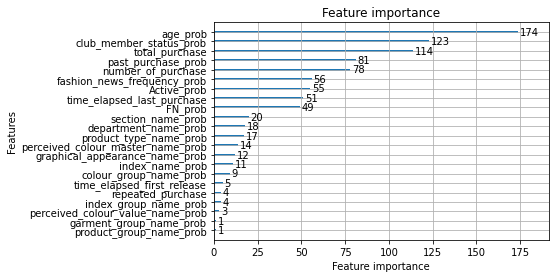

In [22]:
os.makedirs(out_dir,exist_ok=True)
filename = file_str(score,param,t1,t2,t3,t4)
fig = lgb.plot_importance(bst)
fig.get_figure().savefig(os.path.join(out_dir,filename+'.png'))
bst.save_model(os.path.join(out_dir,filename+'.bin'))

****Training****

In [16]:
%%time

t1,t2,t3 = '2020-01-01','2020-08-07','2020-09-22'
trn_df,test_df,gt_df = construct_dataset(
    transactions,
    articles,customers,
    trn_start_time=t1,trn_end_time=t2,
    val_start_time=t2,val_end_time=t3,
    test_start_time=t2,test_end_time=t3,
)

features = [c for c in trn_df.columns if c not in ['article_id','customer_id','label','index','group_size']]
label = 'label'

collator = LightGBMCollator([[trn_df,test_df,gt_df]],features,label)
trn_x,trn_y,trn_grp = collator.get_train_dataset_by_index(0)
collator.construct_eval_dataset()

trn_dataset = lgb.Dataset(trn_x.to_pandas(),trn_y.to_pandas(),group=trn_grp.to_pandas())
val_dataset = lgb.Dataset(collator.test_df[collator.features])
param = dict(
    objective='lambdarank',
    metric='map@12',
    keep_training_booster=True,
    seed=0,
)
num_round = 2
bst = lgb.train(
    param,
    trn_dataset, 
    num_round,
    feval=collator.feval,
    valid_sets=[val_dataset],
)

[LightGBM] [Warning] Unknown parameter: keep_training_booster
[LightGBM] [Warning] Unknown parameter: keep_training_booster
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.291273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4593
[LightGBM] [Info] Number of data points in the train set: 30486046, number of used features: 20
[LightGBM] [Warning] Unknown parameter: keep_training_booster
[1]	valid_0's MAP@12: 0.441998
[2]	valid_0's MAP@12: 0.463684
CPU times: user 5min, sys: 37.4 s, total: 5min 37s
Wall time: 4min 18s


****Submission****

In [12]:
%%time

fname = 'objective:lambdarank_metric:map@12_keep_training_booster:True_early_stopping_round:5_seed:0_learning_rate:0.1_2020-01-01_2020-08-01_2020-09-15_2020-09-22.bin'
bst = lgb.Booster(model_file=os.path.join(out_dir,fname))

article_features=[
    'product_group_name', 'product_type_name', 
    'graphical_appearance_name', 'perceived_colour_value_name', 'colour_group_code', 
    'index_name', 'index_group_name', 
    'section_name', 'department_name',
]
customer_features=[
    'FN','Active','club_member_status','age','fashion_news_frequency',
    ]

reader = pd.read_csv('storage/sample_submission.csv',chunksize=1e5)
print('Number of chunk: ',sum(1 for _ in reader))

submission_df = None
reader = pd.read_csv('storage/sample_submission.csv',chunksize=1e5)
for df in tqdm(reader):
    df = construct_test_df(
        cudf.from_pandas(df[['customer_id']]),
        transactions[(transactions.t_dat > cudf.to_datetime('2020-09-07')) & (transactions.t_dat <= cudf.to_datetime('2020-09-22'))],
        article_features,articles,customer_features,customers,
        how='left',
    )
    df = make_prediction(bst,df.to_pandas(),features,label,k=12)
    submission_df = pd.concat([submission_df,df]) if submission_df is not None else df

0it [00:00, ?it/s]

Number of chunk:  14


/scratch/local/21974473/ipykernel_99249/4083372006.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[group_name] = test_df[group_name]
14it [08:47, 37.65s/it]

CPU times: user 7min 32s, sys: 1min 51s, total: 9min 24s
Wall time: 8min 48s


In [13]:
submission_df['prediction'] = submission_df['prediction'].apply(lambda x: ' '.join(['0'+str(i) for i in x]))

In [14]:
os.makedirs(base_dir,exist_ok=True)
submission_df.to_csv(os.path.join(base_dir,'submission.csv'),index=False)

In [15]:
submission_df.reset_index(drop=True)

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0910601003 0762846031 0914805002 0751471043 08...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918292001 0751471043 0898694001 0909370001 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0866731001 0852584001 0918292001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0919273002 0751471043 0863646001 0894780001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0919273002 0863646001 0751471043 0910601003 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0918292001 0751471043 0898694001 0909370001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846031 0918292001 0863595006 0865799006 09...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0794819001 0884081001 0689365050 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0448509014 0715624001 0918525001 0918522001 07...
